In [38]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules
import pandas as pd
from models import *
from modules.data_io import (
    ALL_DATA,
    load_data_marginals,
    load_data_means,
    load_data_covariances,
    load_single_species_data,
    NUM_TIMES,
    NUM_REPLICAS,
    NUM_MEASUREMENTS,
    CONDITIONS,
)
plt.rc("axes", grid="on")

In [39]:
T_MEASUREMENTS = 3600*np.array([0, 0.5, 1, 2, 4])
SPECIES = ['il1b', 'tnfa']
DATA_MEANS = load_data_means()
DATA_COVARIANCES = load_data_covariances()
DATA_MARGINALS = load_data_marginals()

In [40]:
MODELS = ['3SAA', '3SAB', '3SAC',
          '3SBA', '3SBB', '3SBC',
          '3SCA', '3SCB', '3SCC']

In [41]:
model_classes = {model: CombinedModel(model[-2], model[-1]) for model in MODELS}
parameter_files = {model: f'opt_results/joint_fit/{model}_best_joint_fit.npz' for model in MODELS}
predictions_files = {model:f'predictions/joint_fit/{model}_predictions.npz' for model in MODELS}

# BIC and predictive log-likelihood for combined treatment data

In [42]:
bic = lambda loglike, num_par, data_size : num_par*np.log(data_size) - 2*loglike

# Find number of independent observations used for fitting models
num_data_points = 0
for cond in ['NoInhibitors', 'MG', 'U0126']:
    for rep in ['_0', '_1', '_2', '_3']:
        for time in ['0hr', '30mins', '1hr', '2hr', '4hr']:
            num_data_points += ALL_DATA[cond][rep][time].shape[1]

# Generate the table of different model selection criteria
d = []

for model in MODELS:
    npar = len(model_classes[model].PARAMETERS)

    # Find the fit loglikelihood
    with np.load(parameter_files[model]) as _:
        ll_fit = -1.0*_["fs"]

    # Find the fit BIC
    bic_fit = bic(ll_fit, npar, num_data_points)

    # Find the prediction loglikelihood
    ll_predict = 0
    for s, species in enumerate(SPECIES):
        with np.load(predictions_files[model], allow_pickle=True) as _:
            marginal_fits = [_["predictions"][()][species]["MG_U0126"][f"p{i}"] for i in range(5)]
        data = load_single_species_data("MG_U0126", species)
        for j in range(len(T_MEASUREMENTS)):
            xdata = data[j]
            p = marginal_fits[j]
            p[p<1e-16] = 1e-16
            xdata[xdata>=len(p)] = len(p)-1
            ll_predict += np.sum(np.log(p[xdata]))
        ll_sum = ll_fit + ll_predict

    d.append([model, ll_fit, bic_fit, ll_predict, ll_sum])

In [43]:
model_comparison_table = pd.DataFrame(d, columns=['Model', 'Fit Log-likelihood', 'Fit BIC', 'Prediction Log-likelihood', 'Sum of Fit and Prediction Log-likelihoods'])
print(model_comparison_table)
model_comparison_table.to_csv(r'tables/multi_gene_models.csv',
                              index = False, header=True,
                              float_format='%.2f')
# model_comparison_table = model_comparison_table.drop(index=9)

  Model  Fit Log-likelihood        Fit BIC  Prediction Log-likelihood  \
0  3SAA      -354648.897846  709547.954004              -85201.875111   
1  3SAB      -355948.234857  712146.628025              -85923.221396   
2  3SAC      -356952.177672  714154.513656              -86782.726903   
3  3SBA      -354255.616521  708761.391354              -85238.983475   
4  3SBB      -355727.553033  711705.264377              -85956.846724   
5  3SBC      -355605.220045  711460.598401              -86235.606246   
6  3SCA      -354338.454090  708927.066491              -85069.199253   
7  3SCB      -355754.574837  711759.307986              -85949.040295   
8  3SCC      -356341.175683  712932.509677              -86528.214622   

   Sum of Fit and Prediction Log-likelihoods  
0                             -439850.772957  
1                             -441871.456253  
2                             -443734.904575  
3                             -439494.599996  
4                             -441

# Ranking models in terms of sum of fit and predictive log-likelihood

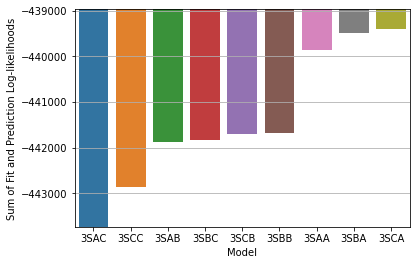

In [44]:
fig, ax = plt.subplots(1,1)
model_comparison_table = model_comparison_table.sort_values(by="Sum of Fit and Prediction Log-likelihoods")
sns.barplot(x=model_comparison_table["Model"],
            y=model_comparison_table["Sum of Fit and Prediction Log-likelihoods"],
            ax=ax
              )
ax.set_ylim([np.min(model_comparison_table["Sum of Fit and Prediction Log-likelihoods"]),
           0.999*np.max(model_comparison_table["Sum of Fit and Prediction Log-likelihoods"])])
fig.savefig("figs/simultaneous_models_ranking.png", dpi=500, bbox_inches="tight")

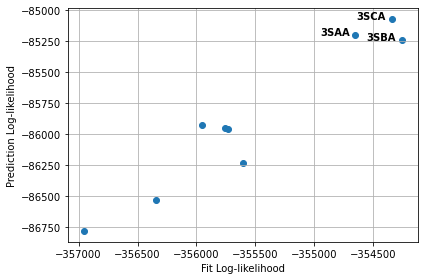

In [45]:
fig, ax = plt.subplots(1,1)
fig.set_tight_layout(True)
ax.scatter(
    model_comparison_table["Fit Log-likelihood"],
    model_comparison_table["Prediction Log-likelihood"]
)
for i in range(model_comparison_table.shape[0]-3, model_comparison_table.shape[0]):
    xcoo = model_comparison_table.iloc[i]["Fit Log-likelihood"]
    ycoo = model_comparison_table.iloc[i]["Prediction Log-likelihood"]
    ax.annotate(model_comparison_table.iloc[i]["Model"], (xcoo - 300, ycoo), fontweight="bold")
ax.autoscale(True, axis="both", tight=False)
ax.set_xlabel("Fit Log-likelihood")
ax.set_ylabel("Prediction Log-likelihood")
fig.savefig("figs/simultaneous_models_performance.png", dpi=500)

# Breaking down of log-likelihoods by species and condition

In [46]:
# Generate the table of different model selection criteria
d = []
columns = ["Model"]
for model in MODELS:
    lbreakdown = []
    for s, species in enumerate(SPECIES):
        for c, cond in enumerate(CONDITIONS):
            with np.load(predictions_files[model], allow_pickle=True) as _:
                marginal_fits = [_["predictions"][()][species][cond][f"p{i}"] for i in range(5)]
            data = load_single_species_data(cond, species)
            ll = 0.0
            for j in range(len(T_MEASUREMENTS)):
                xdata = data[j]
                p = marginal_fits[j]
                p[p<1e-16] = 1e-16
                xdata[xdata>=len(p)] = len(p)-1
                ll += np.sum(np.log(p[xdata]))
            lbreakdown.append(ll)
    d.append([model] + lbreakdown)
for s, species in enumerate(SPECIES):
    for c, cond in enumerate(CONDITIONS):
        columns.append(f"{species}_{cond}")
ll_breakdown_table = pd.DataFrame(d, columns=columns)
print(ll_breakdown_table)
ll_breakdown_table.to_csv(r'tables/multi_gene_models_breakdown.csv',
                              index = False, header=True,
                              float_format='%.2f')

  Model  il1b_NoInhibitors       il1b_MG    il1b_U0126  il1b_MG_U0126  \
0  3SAA      -71832.327924 -65775.332609 -56931.566418  -46552.452607   
1  3SAB      -71813.496139 -65783.983288 -56886.425772  -46489.082077   
2  3SAC      -72656.337739 -65940.500871 -57725.417907  -46887.077289   
3  3SBA      -71563.308601 -65787.577881 -56944.939611  -46578.887290   
4  3SBB      -71548.474724 -65767.493029 -56951.275057  -46528.452893   
5  3SBC      -71593.548128 -65785.837592 -57125.466701  -46549.016945   
6  3SCA      -71550.263440 -65780.084289 -56978.479960  -46414.571041   
7  3SCB      -71520.185143 -65801.347272 -56901.903603  -46422.337567   
8  3SCC      -72224.997432 -65842.026457 -57643.909806  -46640.625364   

   tnfa_NoInhibitors       tnfa_MG    tnfa_U0126  tnfa_MG_U0126  
0      -61159.581529 -49171.442455 -49790.600486  -38649.422504  
1      -61421.349158 -50089.716521 -49955.771466  -39434.139319  
2      -61229.841145 -49435.249108 -49963.932220  -39895.649614  
3    

# Combined model vs Completely independent models

In [47]:
ll_single_gene = pd.read_csv("tables/single_gene_models.csv")
print(ll_single_gene)
print(ll_single_gene.iloc[[0,1,2]])

  Model      il1b_fit       il1b_BIC      tnfa_fit       tnfa_BIC
0   2SA -71606.168137  143287.220139 -61234.157031  122543.197926
1   2SB -72145.632442  144366.148749 -63172.489839  126419.863542
2   3SA -71374.578025  142852.121364 -60818.202475  121739.370263
3   3SB -71441.888354  142986.742022 -61086.196878  122275.359070
4   3SC -71453.014029  143008.993371 -60808.895666  121720.756646
5   3SD -72314.905830  144732.776974 -63271.872460  126646.710233
  Model      il1b_fit       il1b_BIC      tnfa_fit       tnfa_BIC
0   2SA -71606.168137  143287.220139 -61234.157031  122543.197926
1   2SB -72145.632442  144366.148749 -63172.489839  126419.863542
2   3SA -71374.578025  142852.121364 -60818.202475  121739.370263


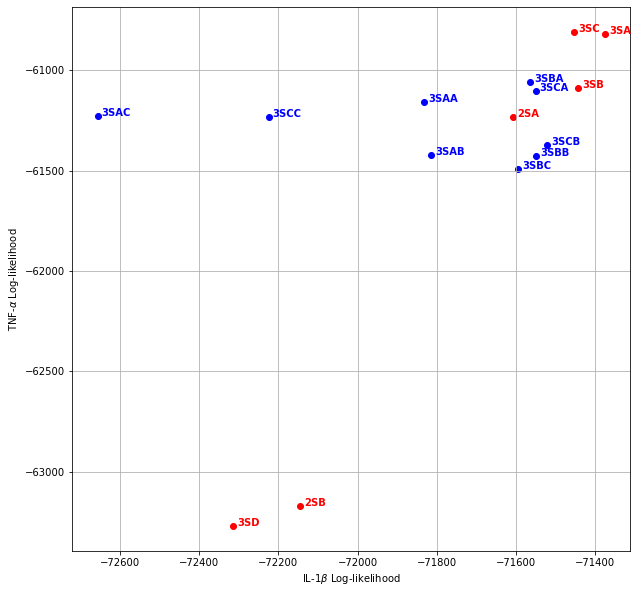

In [48]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)
ax.scatter(ll_single_gene["il1b_fit"],
           ll_single_gene["tnfa_fit"],
           color="red")
for i in range(ll_single_gene.shape[0]):
    xcoo = ll_single_gene.iloc[i]["il1b_fit"]
    ycoo = ll_single_gene.iloc[i]["tnfa_fit"]
    ax.annotate(ll_single_gene.iloc[i]["Model"],
                (xcoo+10, ycoo), fontweight="bold", color="red")

ax.scatter(ll_breakdown_table["il1b_NoInhibitors"],
           ll_breakdown_table["tnfa_NoInhibitors"],
           color="blue")
for i in range(ll_breakdown_table.shape[0]):
    xcoo = ll_breakdown_table.iloc[i]["il1b_NoInhibitors"]
    ycoo = ll_breakdown_table.iloc[i]["tnfa_NoInhibitors"]
    ax.annotate(ll_breakdown_table.iloc[i]["Model"],
                (xcoo+10, ycoo), fontweight="bold", color="blue")
ax.set_xlabel(r"IL-1$\beta$ Log-likelihood")
ax.set_ylabel(r"TNF-$\alpha$ Log-likelihood")
fig.savefig("figs/single_vs_multi_gene_models.png", dpi=500, bbox_inches="tight")
